In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

#X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
#Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

X_motion_CoM = X_motion_CoM_acceleration
Y_motion_CoM = Y_motion_CoM_acceleration

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(5387, 27)
(5387, 3)


# Multivariate Linear Regression (CoM Prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
X_motion_CoM.shape

(5387, 27)

In [8]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, -1] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(2689, 27)
(2689, 3)


## Predict CoM (x) movement

In [9]:
X_motion_CoM_FR_RL[0, :3]

array([0.1, 0.0, 0.0], dtype=object)

In [10]:
Y_motion_CoM_FR_RL[0, :]

array([0.030424394865291193, 0.000628873617372766, 0.000658631123437281],
      dtype=object)

### Linear Regression

In [124]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               #X_motion_CoM_FR_RL[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9687660017007115
RMSE:  0.012612941022553992
The lowest error is:  1.5211127783881784e-05
The highest error is:  0.05567117724734341
The avg. error is:  0.00929804475239129


In [125]:
model_fr_com_x.coef_

array([[ 1.55476542e-02,  2.22044605e-16, -2.22044605e-16,
         1.24370237e-01,  2.22044605e-16,  4.44089210e-16,
         6.66308105e-01, -4.34299860e-01, -1.48564026e-01,
         5.89749574e-01, -5.80109199e-01,  6.61961669e-01,
        -3.40262714e-01,  7.81067377e-01]])

In [127]:
model_fr_com_x.intercept_

array([-0.21192527])

In [128]:
#input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
#output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
#print(output)

Text(0, 0.5, 'Predictions')

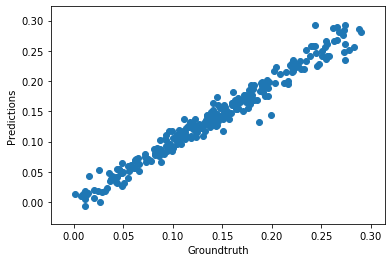

In [129]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [84]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, 0]}->{X_test[idx, 3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}. Error: {abs(Y_test[idx] - prediction)}.')

## Predict CoM -> y

### Linear Regression

In [130]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               #X_motion_CoM_FR_RL[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -1.498258708770917
RMSE:  0.003910822936377916
The lowest error is:  2.6810099917021213e-05
The highest error is:  0.01643989996565666
The avg. error is:  0.00302876038977185


In [131]:
model_fr_com_y.coef_

array([[ 1.08352146e-03,  6.67868538e-17, -5.20417043e-18,
         1.18881486e-03, -1.11022302e-16,  0.00000000e+00,
        -9.88107745e-03,  9.09466687e-02,  8.36384168e-04,
        -8.93606112e-02,  8.58723839e-02, -6.01935483e-01,
         7.68458080e-02,  1.60597778e-01]])

In [132]:
model_fr_com_y.intercept_

array([0.12018495])

Text(0, 0.5, 'Predictions')

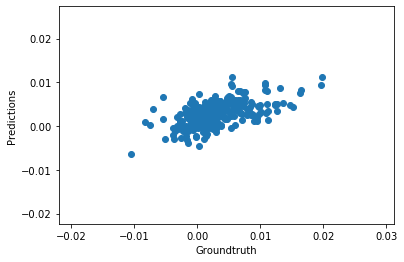

In [118]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [119]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

## Predict CoM -> Yaw

In [133]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # Previous motion command
               X_motion_CoM_FR_RL[:, 3:6], # Current motion command
               #X_motion_CoM_FR_RL[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_CoM_FR_RL[:, 6:8], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 9:11], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.15573449191411382
RMSE:  0.0022684147411440804
The lowest error is:  7.905151592671467e-06
The highest error is:  0.006518841237228044
The avg. error is:  0.0018139024339558735


In [136]:
model_fl_com_theta.coef_

array([[-5.25721471e-04, -1.90819582e-17,  2.42861287e-17,
         2.48761318e-03,  0.00000000e+00,  3.46944695e-18,
        -1.06575947e-02,  2.72193463e-02, -2.84351892e-03,
        -3.15264338e-04, -7.44108469e-02, -4.90586961e-02,
        -4.42046174e-02, -1.03480378e-03]])

In [137]:
model_fl_com_theta.intercept_

array([-0.02405147])

Text(0, 0.5, 'Predictions')

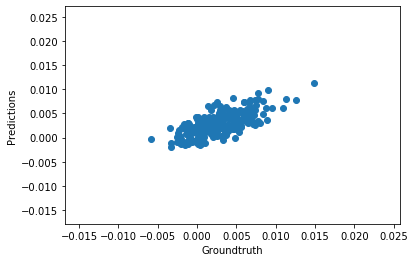

In [123]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")